In [3]:
import pandas as pd
import numpy as np
import scipy.sparse as scp

from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack, diags

In [4]:
columns = ['user_id', 'film_rating', 'film_id']

lines_number = 2 * 10 ** 6

data = pd.read_csv('processed_data.csv', header=None, names=columns, nrows=lines_number)
encoder = OneHotEncoder(categories="auto")

# Применяем one-hot encoding
user_matrix = encoder.fit_transform(np.asarray(data['user_id']).reshape(-1,1))
film_matrix = encoder.fit_transform(np.asarray(data['film_id']).reshape(-1,1))

# Добавляем вектор единиц и формируем матрицу
ones = np.ones(shape=(lines_number, 1))
X = hstack([ones, user_matrix, film_matrix]).tocsr()
y = np.asarray(data['film_rating']).reshape(-1,1)

X,y = shuffle(X,y)

In [5]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2

def RMSE(y_test, y_pred):
    return np.sqrt(MSE(y_test, y_pred))

In [6]:
def make_prediction(X, w, V):
    a = np.sum(np.square(X.dot(V)), axis=1).reshape(-1,1)
    b = np.sum(X.power(2).dot(np.square(V)), axis=1).reshape(-1,1)
    
    return X.dot(w) + 0.5 * (a - b)

In [7]:
def precompute_sum(X, V):
    return X.dot(V)

In [8]:
def gradient_descent_step(X, y, w, V, eta=0.01):
    # Пересчет w
    w += (2 * eta / len(y)) * X.T.dot(y - X.dot(w))
    
    precomputed = precompute_sum(X, V)
    y_pred = make_prediction(X, w, V)
    
    # Пересчет V_i
    for i in range(V.shape[1]):
        a_diagonal = diags(np.array(precomputed)[:, i])
        a = a_diagonal.dot(X)
        
        b_diagonal = diags(V[:, i])
        b = X.power(2).dot(b_diagonal)
        
        V[:, i] += (2 * eta / X.shape[1]) * (a - b).T.dot(y - y_pred).reshape((-1,))
    
    return w, V

In [9]:
def gradient_descent(X, y, w_init, V_init, eta=1e-2, max_iter=1e4):
    weight_dist = np.inf
    w = w_init
    V = V_init
    
    errors = list()
    for i in range(max_iter):
        w_next, V_next = gradient_descent_step(X, y, w, V, eta)
        y_pred = make_prediction(X, w_next, V_next)

        errors.append(MSE(y, y_pred))
        if i % 10 == 0:
            print(f"\tEpoch: {i}, MSE: {errors[i]}")
        
        w = w_next
        V = V_next
        
    return w, V, errors

In [10]:
number_of_splits = 5
number_of_epochs = 100
factors_num = 2

errors     = [0 for _ in range(number_of_splits)]
weights    = [0 for _ in range(number_of_splits)]
factors    = [0 for _ in range(number_of_splits)]

rmse_train = [0 for _ in range(number_of_splits)]
rmse_test  = [0 for _ in range(number_of_splits)]

r2s_train  = [0 for _ in range(number_of_splits)]
r2s_test   = [0 for _ in range(number_of_splits)]

kf = KFold(n_splits=number_of_splits, shuffle=True)
kf.get_n_splits(X)

for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Iteration {i}")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    w_init = np.zeros((X.shape[1], 1))
    V_init = np.zeros((X.shape[1], factors_num))
    
    results = gradient_descent(X_train, y_train, w_init, V_init, eta=0.05, max_iter = number_of_epochs)
    weights[i], factors[i], errors[i] = results
    
    train_preds = make_prediction(X_train, weights[i], factors[i])
    test_preds = make_prediction(X_test, weights[i], factors[i])

    rmse_train[i] = RMSE(y_train, train_preds)
    rmse_test[i] = RMSE(y_test, test_preds)

    r2s_train[i] = R2(y_train, train_preds)
    r2s_test[i] = R2(y_test, test_preds)

Iteration 0
	Epoch: 0, MSE: 11.735420609536618
	Epoch: 10, MSE: 2.362439859547264
	Epoch: 20, MSE: 1.2805798408948819
	Epoch: 30, MSE: 1.1541260346223314
	Epoch: 40, MSE: 1.137838211119285
	Epoch: 50, MSE: 1.1343210196990179
	Epoch: 60, MSE: 1.1323475692523595
	Epoch: 70, MSE: 1.1306198155349216
	Epoch: 80, MSE: 1.1289840630674728
	Epoch: 90, MSE: 1.127418772566706
Iteration 1
	Epoch: 0, MSE: 11.734266805447739
	Epoch: 10, MSE: 2.3616766812743517
	Epoch: 20, MSE: 1.2798858552318284
	Epoch: 30, MSE: 1.1534449248817988
	Epoch: 40, MSE: 1.137161281894335
	Epoch: 50, MSE: 1.133647024739339
	Epoch: 60, MSE: 1.13167634215887
	Epoch: 70, MSE: 1.1299513358480198
	Epoch: 80, MSE: 1.1283183260760516
	Epoch: 90, MSE: 1.1267557721160557
Iteration 2
	Epoch: 0, MSE: 11.737130517187795
	Epoch: 10, MSE: 2.3620590667189676
	Epoch: 20, MSE: 1.2799718834393672
	Epoch: 30, MSE: 1.1534948282216688
	Epoch: 40, MSE: 1.1372059644213464
	Epoch: 50, MSE: 1.1336901111514224
	Epoch: 60, MSE: 1.1317182284473464
	E

Populating the interactive namespace from numpy and matplotlib


D:\Program Files\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['ones', 'hstack', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


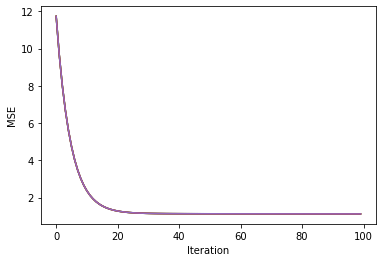

In [11]:
%pylab inline
for error_by_iter in errors:
    plot(range(len(error_by_iter)), error_by_iter)
    xlabel('Iteration')
    ylabel('MSE')

In [12]:
columns = ["Names"]
columns += [f"T{i + 1}" for i in range(number_of_splits)]
columns.append("Mean")
columns.append("Std")

rows =  ["RMSE train", "RMSE test", "R2 train", "R2 test"]
rows += [f"Feature {i + 1}" for i in range(len(weights[0]))]

In [13]:
result_dataframe = pd.DataFrame(columns=columns)
result_dataframe["Names"] = rows
result_dataframe.set_index("Names", inplace=True)

for i in range(number_of_splits):
    data = np.concatenate(([rmse_train[i], rmse_test[i], r2s_train[i], r2s_test[i]], weights[i].reshape((-1,))))
    result_dataframe[f"T{i + 1}"] = data

result_dataframe["Mean"] = result_dataframe.mean(axis=1)
result_dataframe["Std"] = result_dataframe.std(axis=1)

In [14]:
result_dataframe

,T1,T2,T3,T4,T5,Mean,Std
Names,,,,,,,
RMSE train,1.061162,1.060851e+00,1.060868e+00,1.060973,1.061204e+00,1.061012e+00,1.465277e-04
RMSE test,1.060403,1.061653e+00,1.061566e+00,1.061224,1.060282e+00,1.061025e+00,5.772115e-04
R2 train,0.025561,2.561376e-02,2.554115e-02,0.025400,2.558857e-02,2.554083e-02,7.455047e-05
R2 test,0.025473,2.525226e-02,2.556779e-02,0.025999,2.527481e-02,2.551338e-02,2.702615e-04
Feature 1,3.531397,3.531198e+00,3.531802e+00,3.531117,3.530760e+00,3.531255e+00,3.424472e-04
Feature 2,0.000010,1.429235e-06,1.746990e-05,-0.000002,-1.952803e-06,5.068433e-06,7.572733e-06
Feature 3,0.000124,9.861152e-05,8.270262e-05,0.000092,1.176987e-04,1.029981e-04,1.566846e-05
Feature 4,0.000004,-6.962320e-06,-1.292700e-06,-0.000004,-7.520094e-06,-3.009222e-06,4.371415e-06
Feature 5,0.000000,-1.199971e-06,-1.202779e-06,-0.000001,-1.197214e-06,-9.597824e-07,4.798946e-07
